# Building Conversational RAG with OpenAI and Chroma DB: No LangChain or LlamaIndex Required!

## Table of Contents
1. Document Processing and Indexing
2. Setting Up ChromaDB
3. Inserting Data into ChromaDB
4. Semantic Search on ChromaDB
5. Combining ChromaDB and OpenAI for RAG
6. Creating Conversational RAG with Memory


###What is Retrieval Augmented Generation (RAG)?

RAG is a technique that enhances language models by combining them with a retrieval system. It allows the model to access and utilize external knowledge when generating responses.

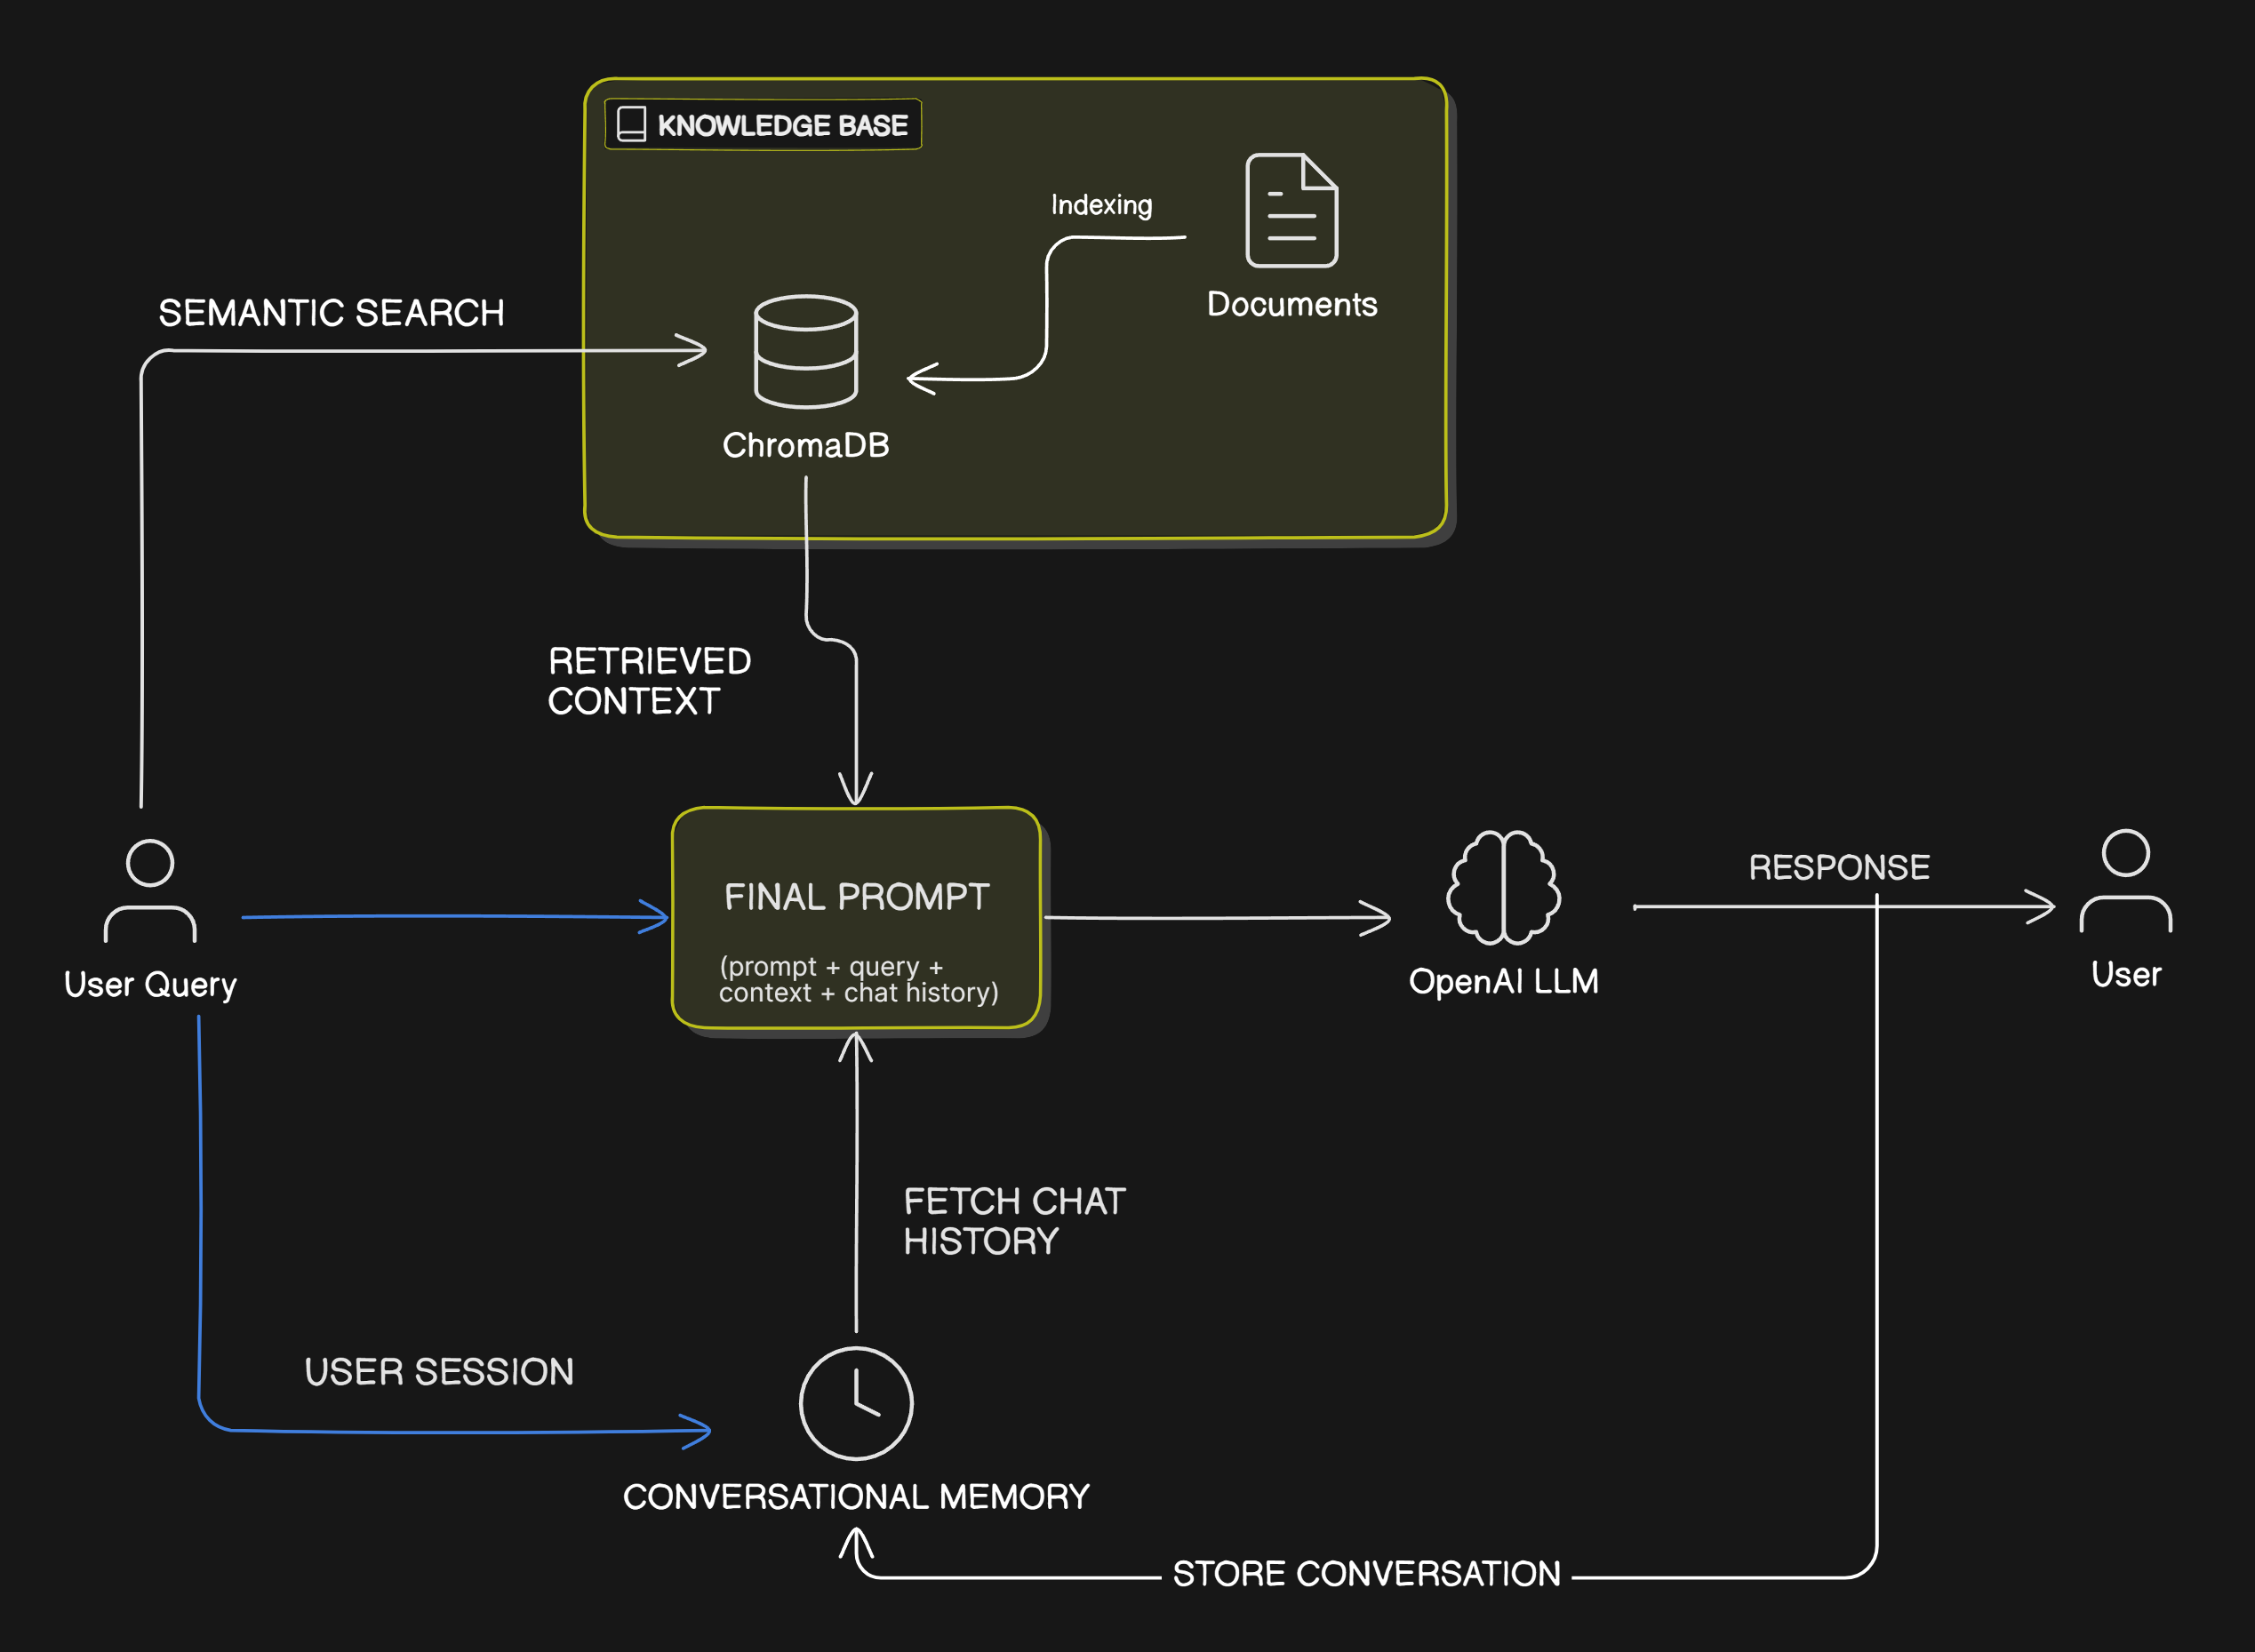

In [1]:
from IPython.display import Image, display

# Display the image
display(Image("/content/rag flowchart new.png",width=800, height=500))

## Installing Necessary Libraries

In [2]:
!pip install -qU chromadb openai pypdf2 python-docx python-multipart sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.0/607.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/

## Document Processing and Indexing

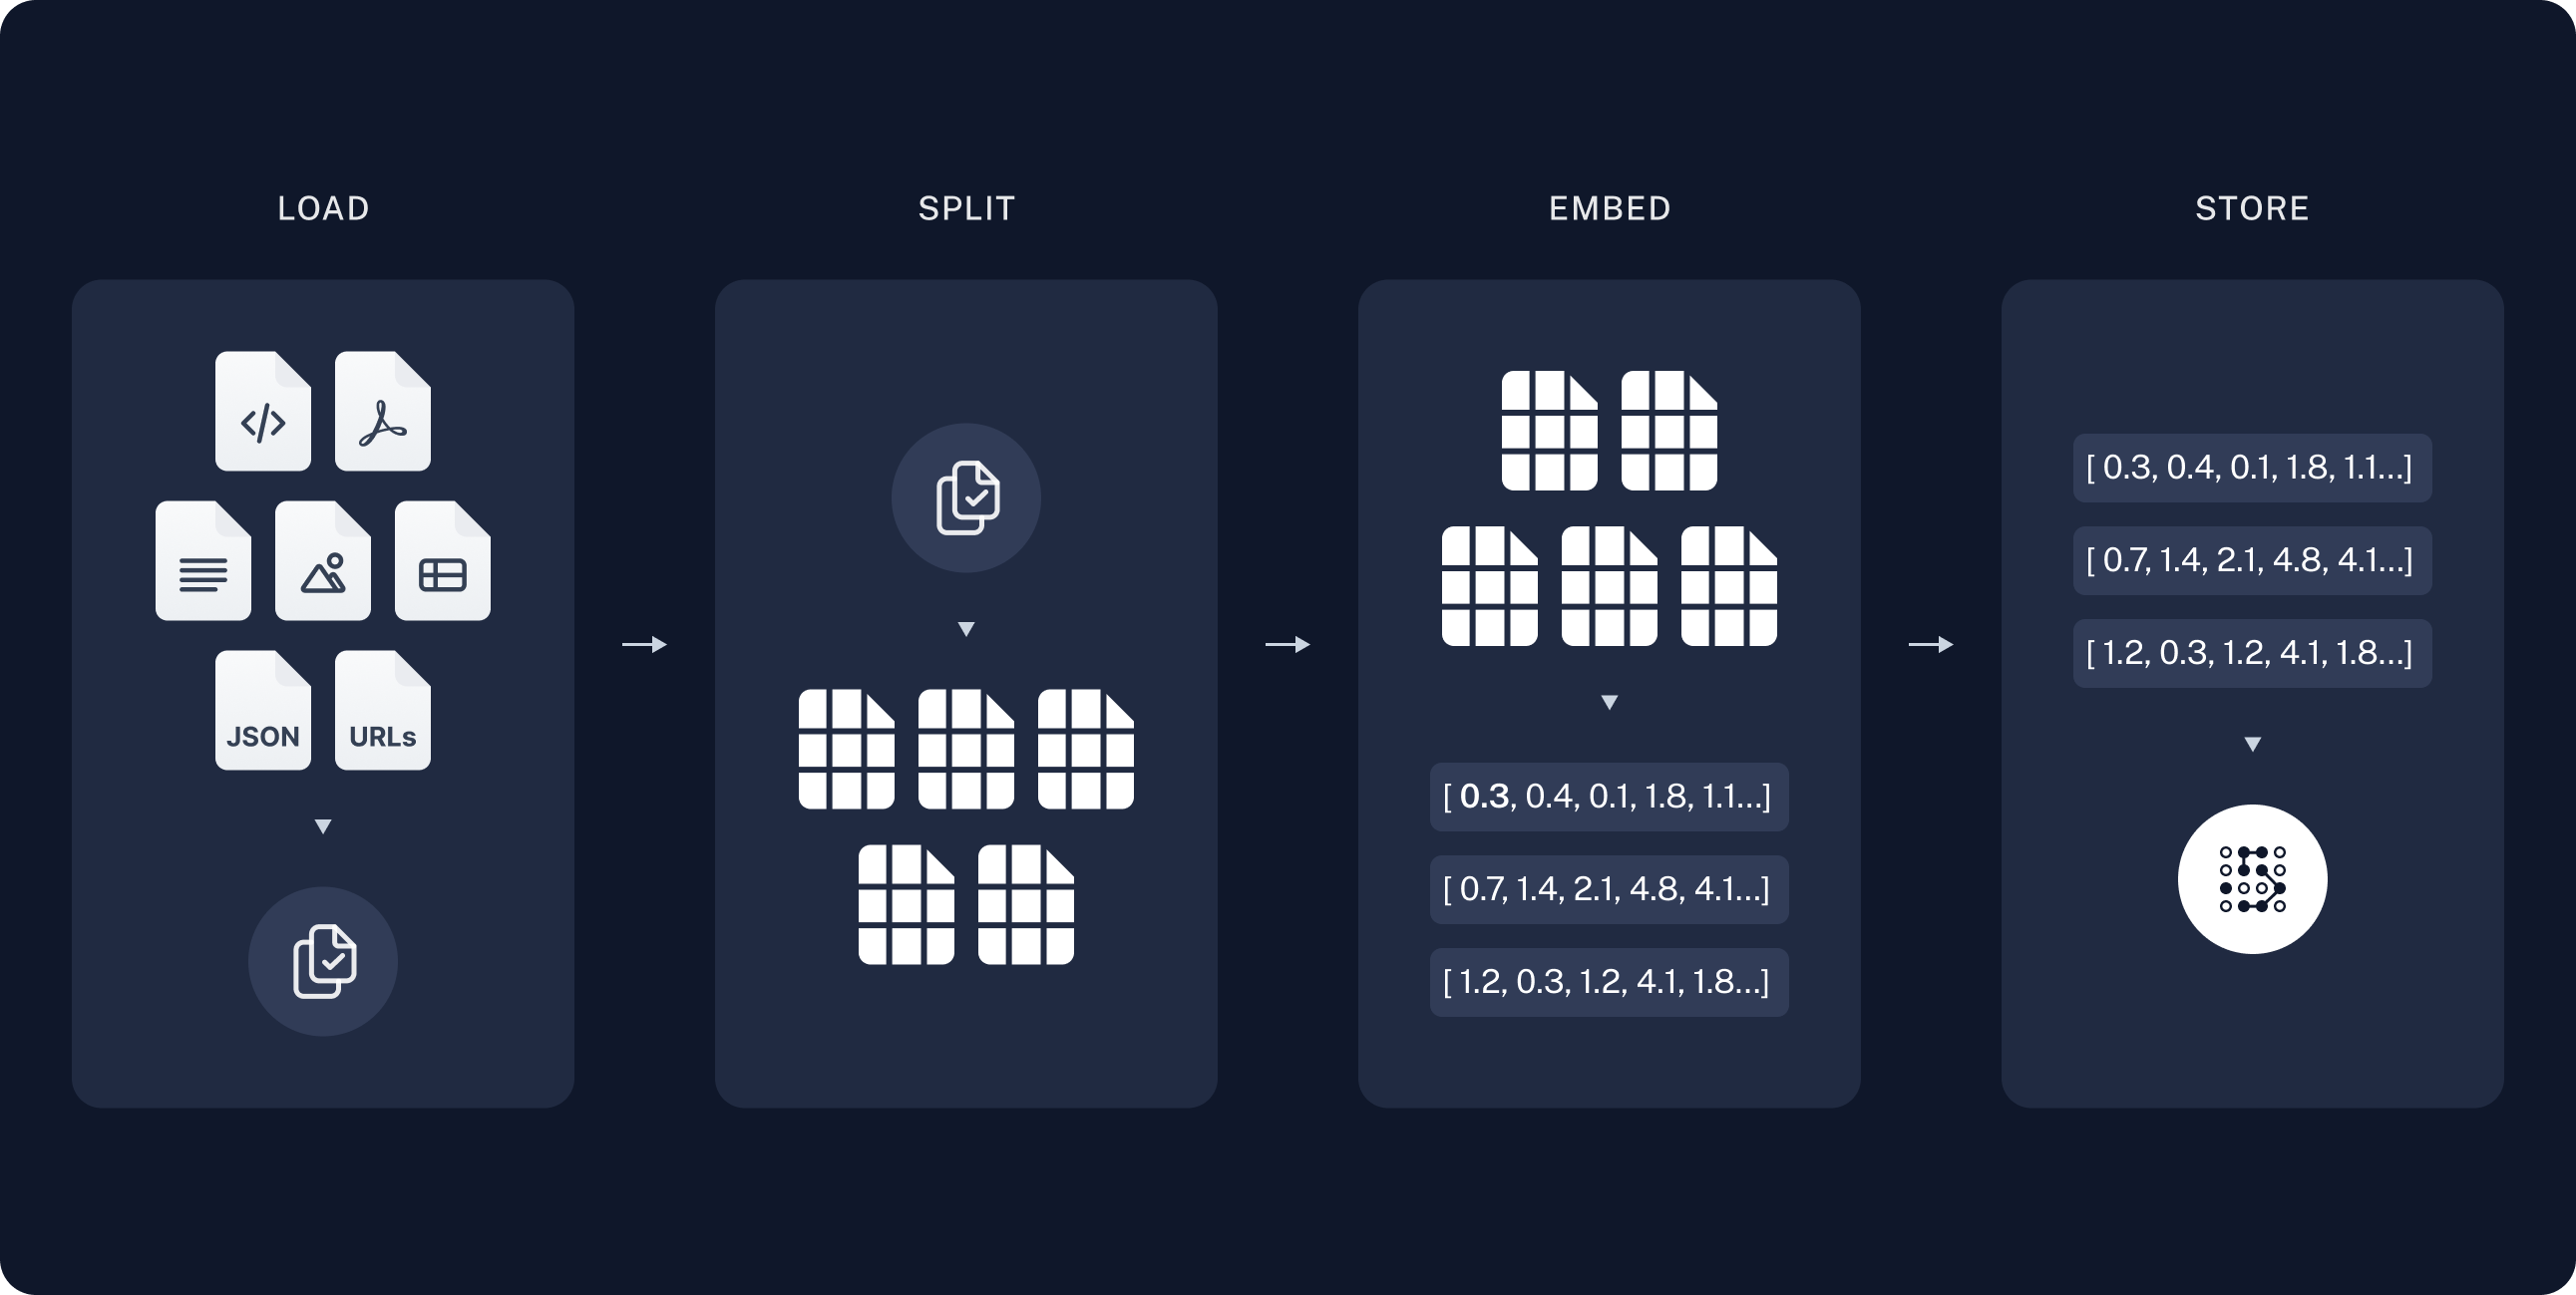

In [3]:
from IPython.display import Image, display

# Display the image
#source: https://python.langchain.com/docs/tutorials/rag/

display(Image("/content/RAG Indexing.png",width=800, height=500))

###Functions to read file contents

In [4]:
import docx
import PyPDF2
import os
def read_text_file(file_path: str):
    """Read content from a txt file"""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def read_pdf_file(file_path: str):
    """Read content from a PDF file"""
    text = ""
    with open(file_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page in pdf_reader.pages:
            text += page.extract_text() + "\n"
    return text

def read_docx_file(file_path: str):
    """Read content from a docx file"""
    doc = docx.Document(file_path)
    return "\n".join([paragraph.text for paragraph in doc.paragraphs])

In [5]:
def read_document(file_path: str):
    """Read document content based on file extension"""
    _, file_extension = os.path.splitext(file_path)
    file_extension = file_extension.lower()

    if file_extension == '.txt':
        return read_text_file(file_path)
    elif file_extension == '.pdf':
        return read_pdf_file(file_path)
    elif file_extension == '.docx':
        return read_docx_file(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")

text = read_document("/content/docs/GreenGrow Innovations_ Company History.docx")
print(text)

GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.

In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.

By 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors to analyze soil composition and provide real-time recommendations for optimal crop growth.

The company's breakthrough 

###Chunking

In [6]:
def split_text(text: str, chunk_size: int = 500):
    """Split text into chunks"""
    sentences = text.replace('\n', ' ').split('. ')
    chunks = []
    current_chunk = []
    current_size = 0

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue

        if not sentence.endswith('.'):
            sentence += '.'

        sentence_size = len(sentence)

        if current_size + sentence_size > chunk_size and current_chunk:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
            current_size = sentence_size
        else:
            current_chunk.append(sentence)
            current_size += sentence_size

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

chunks = split_text(text)
print(chunks[2])

This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors to analyze soil composition and provide real-time recommendations for optimal crop growth. The company's breakthrough came in 2018 with the introduction of the EcoHarvest System, an integrated solution that combined smart irrigation, soil monitoring, and automated harvesting techniques.


In [7]:
len(chunks)

5

## Setting Up ChromaDB

In [8]:
import chromadb
from chromadb.utils import embedding_functions
# import textwrap

In [9]:
# Initialize ChromaDB client
client = chromadb.PersistentClient(path="/content/chroma_db")

# Use sentence-transformer embeddings for embedding our data
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2"
)

collection = client.get_or_create_collection(name="documents_collection", embedding_function=sentence_transformer_ef)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Inserting Data into ChromaDB

In [10]:
def process_document(file_path: str):
    """Process a single document and prepare it for ChromaDB"""
    try:
        # Read the document
        content = read_document(file_path)

        # Split into chunks
        chunks = split_text(content)

        # Prepare metadata
        file_name = os.path.basename(file_path)
        metadatas = [{"source": file_name, "chunk": i} for i in range(len(chunks))]
        ids = [f"{file_name}_chunk_{i}" for i in range(len(chunks))]

        return ids, chunks, metadatas
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return [], [], []

def add_to_collection(collection, ids, texts, metadatas):
    """Add documents to collection in batches"""
    if not texts:
        return

    batch_size = 100
    for i in range(0, len(texts), batch_size):
        end_idx = min(i + batch_size, len(texts))
        collection.add(
            documents=texts[i:end_idx],
            metadatas=metadatas[i:end_idx],
            ids=ids[i:end_idx]
        )

def process_and_add_documents(collection, folder_path: str):
      files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

      for file_path in files:
        print(f"Processing {os.path.basename(file_path)}...")
        ids, texts, metadatas = process_document(file_path)
        add_to_collection(collection, ids, texts, metadatas)
        print(f"Added {len(texts)} chunks to collection")

In [11]:
process_and_add_documents(collection, "/content/docs")

Processing GreenGrow's EcoHarvest System_ A Revolution in Farming.pdf...
Added 6 chunks to collection
Processing Company_ QuantumNext Systems.docx...
Added 2 chunks to collection
Processing GreenGrow Innovations_ Company History.docx...
Added 5 chunks to collection
Processing Company_ TechWave Innovations.docx...
Added 1 chunks to collection
Processing Company_ GreenFields BioTech.docx...
Added 2 chunks to collection


## Semantic Search on ChromaDB

In [12]:
def semantic_search(collection, query: str, n_results: int = 2):
    """Perform semantic search on the collection"""
    return collection.query(
        query_texts=[query],
        n_results=n_results
    )

In [13]:
query = "When was GreenGrow Innovations founded?"
results = semantic_search(collection, query)
results

{'ids': [['GreenGrow Innovations_ Company History.docx_chunk_0',
   'GreenGrow Innovations_ Company History.docx_chunk_4']],
 'embeddings': None,
 'documents': [['GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient. In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture.',
   'Despite its growth, GreenGrow remains committed to its original mission of promoting sustainable farming practices. The company regularly partners with universities and research institutions to advance the field of agricultural technology and hosts annual conferences to share knowledge with farmers and other industry professionals.']],
 'uris': None,
 'data': None,
 'metadatas': [[{'chunk': 0,
    'sour

In [14]:
def print_search_results(results):
    """Print formatted search results"""
    print("\nSearch Results:\n" + "-" * 50)

    for i in range(len(results['documents'][0])):
        doc = results['documents'][0][i]
        meta = results['metadatas'][0][i]
        print(f"\nResult {i + 1}: Source: {meta['source']}, Chunk {meta['chunk']}")
        print(f"Content: {doc}\n")

print_search_results(results)


Search Results:
--------------------------------------------------

Result 1: Source: GreenGrow Innovations_ Company History.docx, Chunk 0
Content: GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient. In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture.


Result 2: Source: GreenGrow Innovations_ Company History.docx, Chunk 4
Content: Despite its growth, GreenGrow remains committed to its original mission of promoting sustainable farming practices. The company regularly partners with universities and research institutions to advance the field of agricultural technology and hosts annual conferences to share knowledge with farmers and other industry professionals.



In [15]:
def get_context_with_sources(results):
    """Get a combined context and formatted sources from search results."""
    # Combine the document chunks into a single context
    context = "\n\n".join(results['documents'][0])

    # Format the sources with metadata information
    sources = [f"{meta['source']} (chunk {meta['chunk']})" for meta in results['metadatas'][0]]

    return context, sources

context, sources = get_context_with_sources(results)
print(context)

GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient. In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture.

Despite its growth, GreenGrow remains committed to its original mission of promoting sustainable farming practices. The company regularly partners with universities and research institutions to advance the field of agricultural technology and hosts annual conferences to share knowledge with farmers and other industry professionals.


## Combining ChromaDB and OpenAI for RAG

## OpenAI Chat Completions API
https://platform.openai.com/docs/guides/text-generation/quickstart?lang=python

In [16]:
import os
os.environ["OPENAI_API_KEY"] = ""
from openai import OpenAI
client = OpenAI()

In [17]:
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "What is Retrieval-Augmented Generation (RAG) in simple words"
        }
    ]
)
print(completion)

ChatCompletion(id='chatcmpl-AMbaAa70oTtPwuA615mJjAOGfKLLw', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Retrieval-Augmented Generation (RAG) is a method that combines two key approaches for improving the way computers understand and generate text. \n\n1. **Retrieval**: First, the system searches a large database or set of documents to find relevant information related to a query or topic.\n2. **Generation**: Next, it uses that information to help create a more accurate and contextually rich response.\n\nIn simple terms, RAG allows a model to pull in specific facts or data from a source when answering questions. This makes the responses more informed and useful because they are based on real information, rather than relying solely on what the model was trained on. It's like having a smart assistant that not only knows a lot but can also look up the latest information to give better answers.", refusal=None, role='assistant', audio=

In [18]:
print(completion.choices[0].message.content)

Retrieval-Augmented Generation (RAG) is a method that combines two key approaches for improving the way computers understand and generate text. 

1. **Retrieval**: First, the system searches a large database or set of documents to find relevant information related to a query or topic.
2. **Generation**: Next, it uses that information to help create a more accurate and contextually rich response.

In simple terms, RAG allows a model to pull in specific facts or data from a source when answering questions. This makes the responses more informed and useful because they are based on real information, rather than relying solely on what the model was trained on. It's like having a smart assistant that not only knows a lot but can also look up the latest information to give better answers.


Functions to get prompt and OpenAI Response

In [19]:
def get_prompt(query: str, context: str):
    """Prompt for Response Generation"""
    prompt = f"""Based on the following context, please answer the question.
    If the answer cannot be derived from the context, say "I cannot answer this based on the provided context."

    Context:
    {context}

    Question: {query}

    Answer:"""

    return prompt

def generate_response(query: str, context: str):
    """Generate a response using OpenAI"""

    prompt = get_prompt(query, context)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=500
    )

    return response.choices[0].message.content

##Perform RAG query

In [20]:
def rag_query(collection, query: str, n_chunks: int = 2):
    """Perform RAG query: retrieve relevant chunks and generate answer"""
    # Get relevant chunks
    results = semantic_search(collection, query, n_chunks)
    context, sources = get_context_with_sources(results)

    # Generate response
    response = generate_response(query, context)

    return response, sources

In [21]:
query = "When was GreenGrow Innovations founded?"
response, sources = rag_query(collection, query)

# Print results
print("\nQuery:", query)
print("\nAnswer:", response)
print("\nSources used:")
for source in sources:
    print(f"- {source}")


Query: When was GreenGrow Innovations founded?

Answer: GreenGrow Innovations was founded in 2010.

Sources used:
- GreenGrow Innovations_ Company History.docx (chunk 0)
- GreenGrow Innovations_ Company History.docx (chunk 4)


## Creating Conversational RAG with Memory

In [22]:
import uuid
from datetime import datetime
import json

In [23]:
# In-memory conversation store
conversations = {}

def create_session():
    """Create a new conversation session"""
    session_id = str(uuid.uuid4())
    conversations[session_id] = []
    return session_id

def add_message(session_id: str, role: str, content: str):
    """Add a message to the conversation history"""
    if session_id not in conversations:
        conversations[session_id] = []

    conversations[session_id].append({
        "role": role,
        "content": content,
        "timestamp": datetime.now().isoformat()
    })

In [24]:
def get_conversation_history(session_id: str, max_messages: int = None):
    """Get conversation history for a session"""
    if session_id not in conversations:
        return []

    history = conversations[session_id]
    if max_messages:
        history = history[-max_messages:]

    return history

def format_history_for_prompt(session_id: str, max_messages: int = 5):
    """Format conversation history for inclusion in the prompt"""
    history = get_conversation_history(session_id, max_messages)
    formatted_history = ""

    for msg in history:
        role = "Human" if msg["role"] == "user" else "Assistant"
        formatted_history += f"{role}: {msg['content']}\n\n"

    return formatted_history

##Contextualizing the question

First Question : When was GreenGrow Innovations founded?

Follow up : Where is it headquartered?

contextualize_query : Where is GreenGrow Innovations headquartered?

In [25]:
def contextualize_query(query, conversation_history, client):
    """Generate a standalone query based on conversation history and the latest user query."""
    # Define the system prompt for context-aware question reformulation
    contextualize_q_system_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )

    # Make the API call to rephrase the question into a standalone format
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": contextualize_q_system_prompt},
            {"role": "user", "content": f"Chat history:\n{conversation_history}\n\nQuestion:\n{query}"}
        ]
    )

    # Return the standalone query reformulated by the model
    return completion.choices[0].message.content


In [26]:
def get_prompt(context, conversation_history, query):
  prompt = f"""Based on the following context and conversation history, please provide a relevant and contextual response.
    If the answer cannot be derived from the context, only use the conversation history or say "I cannot answer this based on the provided information."

    Context from documents:
    {context}

    Previous conversation:
    {conversation_history}

    Human: {query}

    Assistant:"""
  return prompt

In [27]:
# Updated generate response function with conversation history also passed for Chatbot Memory
def generate_response(query: str, context: str, conversation_history: str = ""):
    """Generate a response using OpenAI with conversation history"""
    prompt = get_prompt(context, conversation_history, query)
    # print(prompt)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt}
        ],
        temperature=0,
        max_tokens=500
    )

    return response.choices[0].message.content

In [37]:
def conversational_rag_query(
    collection,
    query: str,
    session_id: str,
    n_chunks: int = 3
):
    """Perform RAG query with conversation history"""
    # Get conversation history
    conversation_history = format_history_for_prompt(session_id)

    # Handle follo up questions
    query = contextualize_query(query, conversation_history, client)
    print("Contextualized Query:", query)

    # Get relevant chunks
    context, sources = get_context_with_sources(
        semantic_search(collection, query, n_chunks)
    )
    print("Context:", context)
    print("Sources:", sources)


    response = generate_response(query, context, conversation_history)

    # Add to conversation history
    add_message(session_id, "user", query)
    add_message(session_id, "assistant", response)

    return response, sources

### Conversation 1

In [38]:
session_id = create_session()
print(session_id)

481523f0-0946-439e-9908-ca759fb25c1e


In [39]:
query = "When was GreenGrow Innovations founded?"
response, sources = conversational_rag_query(
            collection,
            query,
            session_id
)
print(response)

Contextualized Query: When did GreenGrow Innovations come into existence?
Context: GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient. In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture.

This system caught the attention of large-scale farmers across the United States, propelling GreenGrow to national prominence. Today, GreenGrow Innovations employs over 200 people and has expanded its operations to include offices in California and Iowa. The company continues to focus on developing sustainable agricultural technologies, with ongoing projects in vertical farming, drought-resistant crop development, and AI-powered farm management systems.

Despite its growth, GreenGrow re

In [40]:
query = "Where is it located?"
response, sources = conversational_rag_query(
            collection,
            query,
            session_id
)
print(response)

Contextualized Query: What is the location of GreenGrow Innovations?
Context: GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient. In its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture.

This system caught the attention of large-scale farmers across the United States, propelling GreenGrow to national prominence. Today, GreenGrow Innovations employs over 200 people and has expanded its operations to include offices in California and Iowa. The company continues to focus on developing sustainable agricultural technologies, with ongoing projects in vertical farming, drought-resistant crop development, and AI-powered farm management systems.

Despite its growth, GreenGrow remains

In [35]:
conversations

{'89f32c97-22cd-41a4-af56-d4c33a33f5fd': [{'role': 'user',
   'content': 'When was the company GreenGrow Innovations established?',
   'timestamp': '2024-10-26T13:58:52.396706'},
  {'role': 'assistant',
   'content': 'GreenGrow Innovations was founded in 2010.',
   'timestamp': '2024-10-26T13:58:52.396722'},
  {'role': 'user',
   'content': 'What is the location of GreenGrow Innovations?',
   'timestamp': '2024-10-26T13:59:25.114471'},
  {'role': 'assistant',
   'content': 'GreenGrow Innovations started in a small garage in Portland, Oregon. Today, the company has expanded its operations to include offices in California and Iowa.',
   'timestamp': '2024-10-26T13:59:25.114493'}],
 'af89be67-0967-4d3b-a1e1-3d1e49a98bde': [{'role': 'user',
   'content': 'When was GreenGrow Innovations founded?',
   'timestamp': '2024-10-26T14:00:12.382326'},
  {'role': 'assistant',
   'content': 'GreenGrow Innovations was founded in 2010.',
   'timestamp': '2024-10-26T14:00:12.382342'}]}